# **Electricity Demand Forecasting**

## **1. Project Overview**

This project is about predicting how much electricity people will use in the future. To do this, we use data about how much electricity has been used in the past, the weather, and other factors like prices. This prediction is important because it helps energy companies make sure there's enough electricity available without wasting resources.

## **2. Problem Statement**

The main goal is to predict the total electricity load (how much electricity is used) at different times. This helps in planning energy production efficiently, so there’s no shortage or excess. For example, if we can predict that a lot of electricity will be needed tomorrow, power plants can be prepared to generate enough.

## **3. Dataset Overview**

We are using two main sets of data:

- **Energy Dataset**: This contains information about how much electricity was generated from different sources (like solar, wind, coal), forecasts (predictions made earlier), actual electricity loads, and energy prices.


- **Weather Dataset**: This includes weather information like temperature, pressure, humidity, wind speed, and conditions (e.g., clear, rainy) for different cities.

## **4. Imports**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## **5. Data Loading and Initial Exploration**

In [24]:
# Load the datasets available
energy = pd.read_csv('./datasets/energy_dataset.csv')
weather = pd.read_csv('./datasets/weather_features.csv')

In [25]:
# Look at the first few rows to understand what’s inside
print(energy.head())
print(weather.head())

                        time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.

In [26]:
# Check if there are any missing pieces of data (missing values)
print(energy.isna().mean() * 100)
print(weather.isna().mean() * 100)

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil coal-derived gas               0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation fossil oil shale                      0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation marine                                0.054187
generation nuclear                               0.048483
generation other                                 0.051335
generation oth

## **6. Data Cleaning and Preprocessing**

Apart from the **forecast wind offshore eday ahead** and **generation hydro pumped storage aggregated** columns that are completely empty, the rest of the columns have percentages less than **0.06%**. We will drop all null values.

### **6.1 Handling Missing Values**

In [33]:
# Drop the empty columns
energy = energy.drop(columns=['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'])

# Remove any remaining rows that have missing data
energy = energy.ffill()

# Do the same for the weather data
weather = weather.ffill()

### **6.2 Data Type Correction**

In [34]:
# Convert the time columns to the correct date and time format
energy['time'] = pd.to_datetime(energy['time'], utc=True)
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'], utc=True)

In [35]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,49.0,196.0,0.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,50.0,195.0,0.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,50.0,196.0,0.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,50.0,191.0,0.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,42.0,189.0,0.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


### **6.3 Align the Data**

In [36]:
data = pd.merge(energy, weather, left_on='time', right_on='dt_iso', how='inner')

## **7. Exploratory Data Analysis (EDA)**

### **7.1 Basic Statistical Summary**

In [37]:
# Get a quick summary of the data
data.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.0,178396.000000,178396.000000,178396.000000,178396.0,178396.0,178396.0,178396.000000,...,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,383.018201,448.288936,0.0,5626.221367,4254.639824,298.170901,0.0,0.0,0.0,475.108270,...,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,85.249452,354.345050,0.0,2203.619289,1961.250231,52.462168,0.0,0.0,0.0,792.286498,...,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,333.000000,0.000000,0.0,4127.000000,2526.000000,263.000000,0.0,0.0,0.0,0.000000,...,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,366.000000,509.000000,0.0,4972.000000,4473.000000,300.000000,0.0,0.0,0.0,67.000000,...,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,430.000000,757.000000,0.0,6436.000000,5837.000000,330.000000,0.0,0.0,0.0,615.000000,...,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,4523.000000,...,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [52]:
print(data[data['generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'dt_iso',
       'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h']].head(1))

KeyError: ('generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h')

In [50]:
data.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual', 'dt_iso',
       'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id',

### **7.2 Correlation Analysis**

In [47]:
# Separate the numerical columns
numerical_cols = data.drop(columns=['time', 'weather_main', 'weather_description', 'weather_icon'])
print(numerical_cols.head(1))

   generation biomass  generation fossil brown coal/lignite  \
0               447.0                                 329.0   

   generation fossil coal-derived gas  generation fossil gas  \
0                                 0.0                 4844.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   

   generation hydro pumped storage consumption  ...  wind_deg  rain_1h  \
0                                        863.0  ...        62      0.0   

   rain_3h  snow_3h  clouds_all  weather_id  hour  day  month  weekday  
0      0.0      0.0           0         800    23   31     12        2  

[1 rows x 44 columns]


In [48]:
# Check for correlation between features
corr = numerical_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

ValueError: could not convert string to float: 'Valencia'

### **7.3 Time Series Visualization**

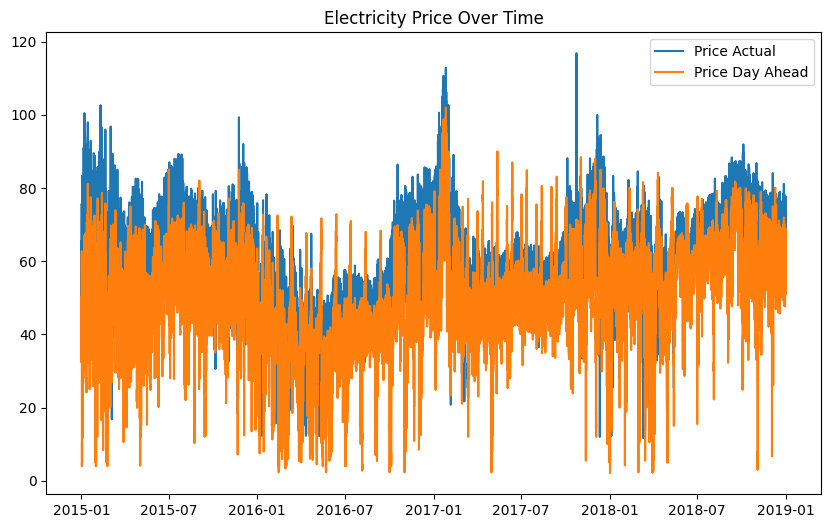

In [38]:
# Visualize key trends
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['price actual'], label='Price Actual')
plt.plot(data['time'], data['price day ahead'], label='Price Day Ahead')
plt.legend()
plt.title('Electricity Price Over Time')
plt.show()

## **8. Feature Engineering**

### **8.1 Create New Features**

In [39]:
# Extract useful time-based features
data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month
data['weekday'] = data['time'].dt.weekday

### **8.2 Select Relevant Features**

In [40]:
features = ['generation biomass', 'generation fossil gas', 'generation solar', 
            'generation wind onshore', 'total load actual', 'temp', 'pressure', 
            'humidity', 'wind_speed', 'hour', 'weekday']
X = data[features]
y = data['price actual']


### **8.3 Data Splitting and Scaling**

In [41]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **9. Model Building**

### **9.1 Train a Random Forest Regressor**

In [42]:
# We use a Random Forest model to predict electricity prices
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

### **9.2 Model Evaluation**

In [43]:
# Model performance evaluation using metrics like Mean Squared Error (MSE) and R²
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 13.825336863515135
R-squared: 0.9309480511315742


## **10. Conclusion and Insights**

- **Performance Summary**: The Random Forest model performed with a mean squared error of **13.83** and an R-squared value of **0.93**. This indicates that the model can reasonably predict electricity prices based on past energy usage and weather data, although there may be room for improvement in predictive accuracy.

- **Key Insights from EDA**: Summarize any important relationships found during the exploratory data analysis.

- **Next Steps**: Suggest further improvements, such as trying other machine learning models, optimizing hyperparameters, or incorporating additional external datasets.